**Приоритизация гипотез**  

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.  

**Задача**  

    Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
    Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
    Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.
    
**Анализ A/B-теста**

Результаты A/B-тестов описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.  

**Задача**  

Проанализировать A/B-тест:  

    Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
    Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
    Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
    Построить график кумулятивной конверсии по группам. Сделать выводы и предположения.
    Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения.
    Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
    Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
    Построить точечный график стоимостей заказов. Сделать выводы и предположения.
    Построить 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
    Построить статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.
    Построить статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
    Построить статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.
    Построить статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
    Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

**Описание данных**  

**Данные для первой части**  

Файл /datasets/hypothesis.csv.  

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**  

Файл /datasets/orders.csv.  

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.  
    
Файл /datasets/visitors.csv.

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

# Подготовка данных к анализу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import datetime as dt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters

In [2]:
# настройка отображения
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_colwidth = 100

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

hypothesis.name = 'hypothesis'
orders.name = 'orders'
visitors.name = 'visitors'

file_list = [hypothesis, orders, visitors]

In [4]:
# функция выводящая общую информацию по каждому файлу
def general_info(list):
    
    for file in file_list:
        print('-' * 100, '\n')
        print(file.name)
        file.columns = map(str.lower, file.columns)
        display(file.info())
        display(file.describe().T)
        
        # данный блок исправляет ошибку, которая не позволяет выводит количество строк больше,
        # чем количество строк в самом дата фрейме
        if file.shape[0] > 10:
            display(file.sample(10))
        else:
            display(file.sample(file.shape[0]))

        
general_info(file_list)

---------------------------------------------------------------------------------------------------- 

hypothesis
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,count,mean,std,min,25%,50%,75%,max
reach,9.00,4.78,3.15,1.00,3.00,3.00,8.00,10.00
impact,9.00,4.78,3.19,1.00,3.00,3.00,7.00,10.00
confidence,9.00,5.56,3.05,1.00,3.00,7.00,8.00,9.00
efforts,9.00,4.89,2.80,1.00,3.00,5.00,6.00,10.00


,hypothesis,reach,impact,confidence,efforts
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6


---------------------------------------------------------------------------------------------------- 

orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionid    1197 non-null int64
visitorid        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,count,mean,std,min,25%,50%,75%,max
transactionid,"1,197.00","2,155,621,385.53","1,229,084,904.76","1,062,393.00","1,166,775,572.00","2,145,193,898.00","3,237,740,112.00","4,293,855,558.00"
visitorid,"1,197.00","2,165,960,143.10","1,236,014,192.15","5,114,589.00","1,111,826,046.00","2,217,984,702.00","3,177,606,451.00","4,283,872,382.00"
revenue,"1,197.00","8,348.01","39,191.13",50.00,"1,220.00","2,978.00","8,290.00","1,294,500.00"


,transactionid,visitorid,date,revenue,group
762,3047372556,171459513,2019-08-07,5690,B
1141,1801818165,2941133924,2019-08-13,300,B
198,2206098194,2880866577,2019-08-02,1690,A
445,2656017279,2288159513,2019-08-03,390,A
205,1993640374,835561402,2019-08-02,500,B
902,1243954217,467975735,2019-08-27,160,A
81,2206140518,3499733621,2019-08-16,5400,B
1133,2645975327,1285103033,2019-08-13,5440,B
51,794298435,2914239125,2019-08-16,18100,B
3,3797467345,1196621759,2019-08-15,9759,B


---------------------------------------------------------------------------------------------------- 

visitors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,count,mean,std,min,25%,50%,75%,max
visitors,62.00,607.29,114.40,361.00,534.00,624.50,710.50,770.00


,date,group,visitors
20,2019-08-21,A,646
10,2019-08-11,A,718
53,2019-08-23,B,546
30,2019-08-31,A,699
31,2019-08-01,B,713
21,2019-08-22,A,609
17,2019-08-18,A,668
15,2019-08-16,A,361
47,2019-08-17,B,421
57,2019-08-27,B,720


In [5]:
# проверяем на дубли
def check_duplicated(list):
    for file in list:
        print('Количество дубликатов в {}'.format(file.name), file.duplicated().sum())

check_duplicated(file_list)

Количество дубликатов в hypothesis 0
Количество дубликатов в orders 0
Количество дубликатов в visitors 0


Необходимо привести дату к соответствеющему типу данных, сделаем это далее

# Приоритизация гипотез
## Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.

In [6]:
# рассчитываем ICE
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


## Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.

In [7]:
# рассчитываем RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


## Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

In [8]:
# формируем сравнительную таблицу ICE и RICE
hypothesis_ice_index = hypothesis['ICE'].sort_values(ascending=False).reset_index()
hypothesis_ice_index.columns = ['ICE_index', 'ICE']

hypothesis_rice_index = hypothesis['RICE'].sort_values(ascending=False).reset_index()
hypothesis_rice_index.columns = ['RICE_index', 'RICE']

hypothesis_index = hypothesis_ice_index.join(hypothesis_rice_index)

display(hypothesis_index[['ICE_index', 'RICE_index']])
display(hypothesis)

,ICE_index,RICE_index
0,8,7
1,0,2
2,7,6
3,6,0
4,2,8
5,1,3
6,5,5
7,3,1
8,4,4


,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00,56.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00,40.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20


**Вывод**  

Видны сильные изменения в преоритизации гипотез. Данные изменения связаны с тем, что ICE показывает влияние гипотезы, в то время, как RICE показывает охват аудитории, так же в RICE параметр Reach больше, чем у других. Если расмотреть на примере первых трех гипотез, то видно, что в ICE (в формуле ICE нет параметра Reach, но именно он изменил приоретизацию при использовании RICE) Reach равен 1, 3, 10, в RICE reach равен 10, 8, 5.

# Анализ A/B-теста

## Построить график кумулятивной выручки по группам. Сделать выводы и предположения.

In [9]:
# Приводит колонку date к типу данных datetime
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

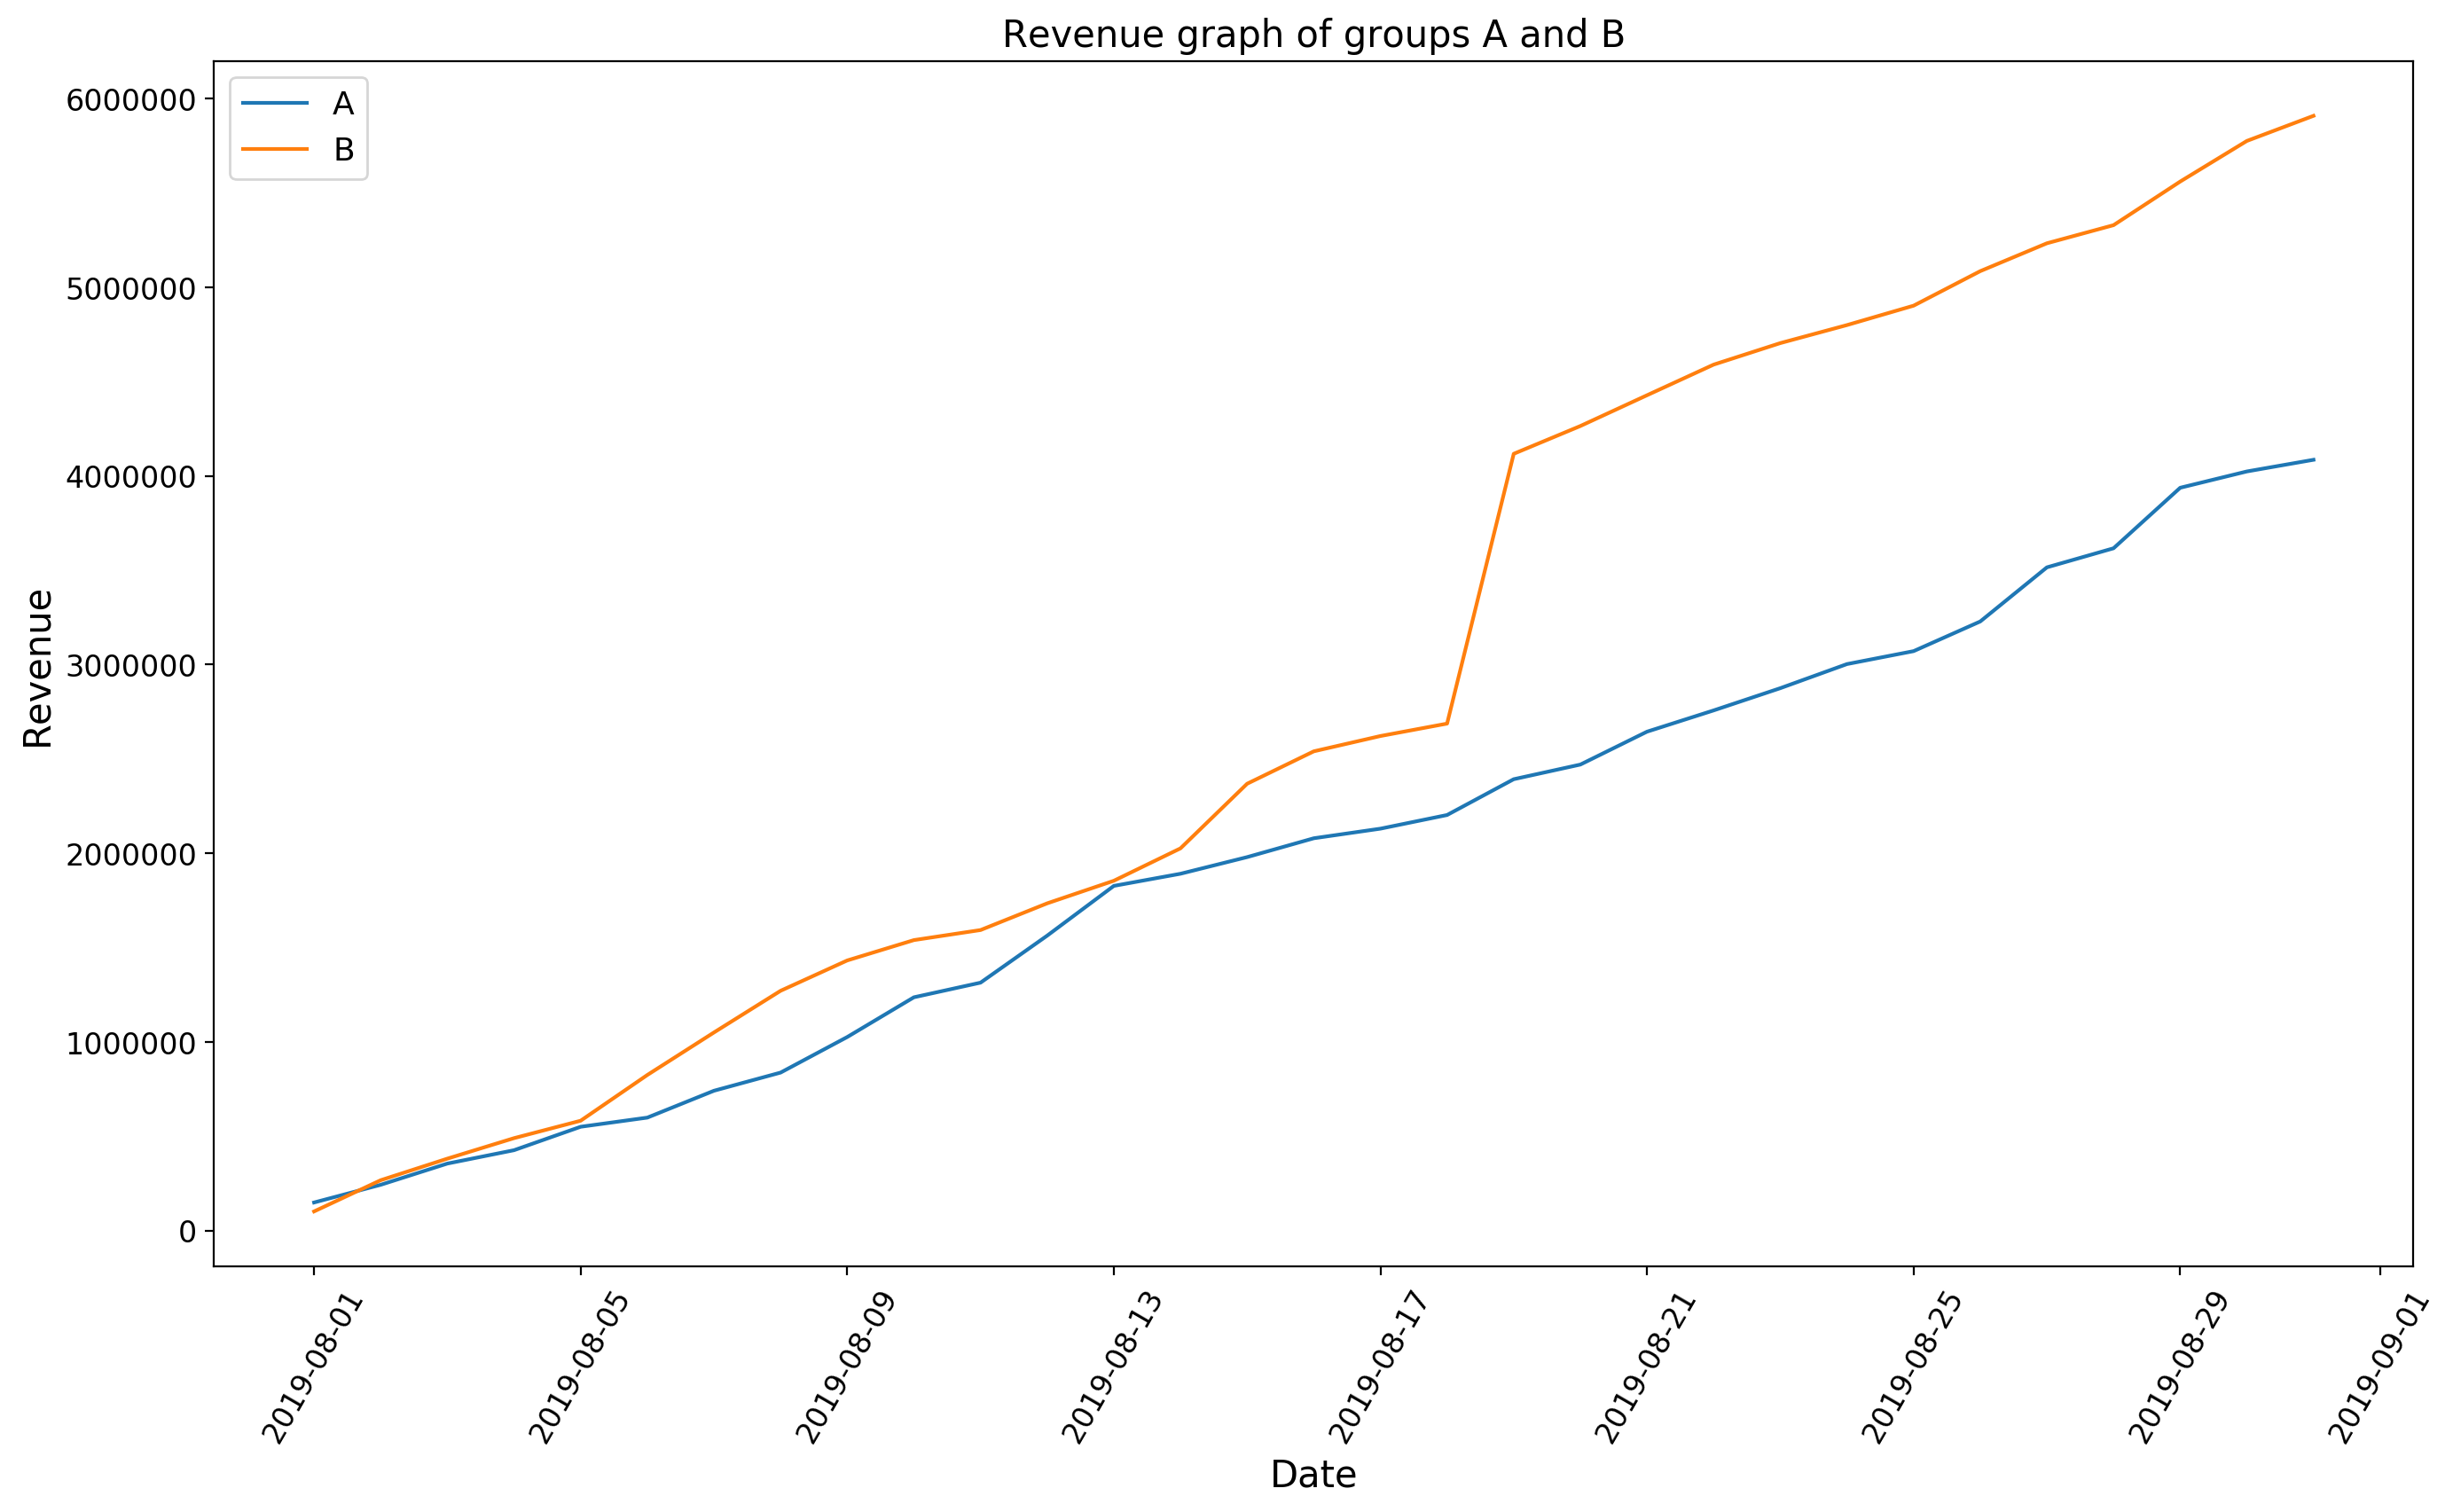

In [10]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionid': pd.Series.nunique,
            'visitorid': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# считаем кумулятивную конверсию
cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]

# строим график
def group_chart(x, y, **kwargs):
    register_matplotlib_converters()
    
    # задаем размер значений на осях
    plt.rcParams['font.size'] = '12'
    
    # задаем размер графика
    plt.figure(figsize=(16, 9), dpi=200)
    
    if y == 'Revenue':
        # строим график выручки группы А
        plt.plot(kwargs['a']['date'], kwargs['a']['revenue'], label='A')
        # строим график выручки группы B
        plt.plot(kwargs['b']['date'], kwargs['b']['revenue'], label='B')
        # добавляем легенду
        plt.legend(fontsize=13)
        # добавляем название графика
        plt.title('Revenue graph of groups A and B', fontsize=15)
    elif y == 'Average check':
        # строим график среднего чека группы А
        plt.plot(kwargs['a']['date'], kwargs['a']['revenue']/kwargs['a']['orders'], label='A')
        # строим график среднего чека группы B
        plt.plot(kwargs['b']['date'], kwargs['b']['revenue']/kwargs['b']['orders'], label='B')
        # добавляем легенду
        plt.legend(fontsize=13)
        # добавляем название графика
        plt.title('Graph of the average check of groups A and B', fontsize=15)
    elif y == 'Cumulative average check':
        # cтроим отношение средних чеков
        plt.plot(kwargs['m']['date'], (kwargs['m']['revenueB']/kwargs['m']['ordersB'])\
                 /(kwargs['m']['revenueA']/kwargs['m']['ordersA'])-1)
        # добавляем название графика
        plt.title('Graph of the cumulative average check', fontsize=15)
        # добавляем ось X
        plt.axhline(y=0, color='black', linestyle='--')
    elif y == 'Cumulative conversion':
        # строим график
        plt.plot(kwargs['a']['date'], kwargs['a']['conversion'], label='A')
        # строим график
        plt.plot(kwargs['b']['date'], kwargs['b']['conversion'], label='B')
        # добавляем легенду
        plt.legend(fontsize=13)
        # добавляем название графика
        plt.title('Graph of the cumulative conversion', fontsize=15)
        # добавляем ограничения по осям
        plt.axis(['2019-07-31', '2019-09-01', 0.025, 0.04])
    elif y == 'Relative change in cumulative conversion':
        plt.plot(kwargs['m']['date'], kwargs['m']['conversionB']\
                 /kwargs['m']['conversionA']-1,\
                 label="Relative increase in conversion of group B relative to group A ")
        # добавляем легенду
        plt.legend(fontsize=13)
        # добавляем название графика
        plt.title('Graph of the cumulative conversion', fontsize=15)
        # добавляем ось X
        plt.axhline(y=0, color='black', linestyle='--')
        # добавляем ось X
        plt.axhline(y=0.14, color='red', linestyle='--')
        # добавляем ограничения по осям
        plt.axis(['2019-07-31', '2019-09-01', -0.15, 0.25])
    elif kwargs['anchor'] == 'scatter':
        plt.scatter(kwargs['u'], kwargs['o'])
        # добавляем название графика
        plt.title(kwargs['title'], fontsize=15)
    # задаем названия оси по X и Y  
    plt.xlabel(x, fontsize=15)
    plt.ylabel(y, fontsize=15)
    # задаем поворот значений на оси X  
    plt.xticks(rotation=60)

# строим график
group_chart('Date', 'Revenue', a = cumulativeRevenueA, b = cumulativeRevenueB)

**Вывод**  

Выручка группы А равомерно увеличивается в течение всего теста, в то время как выручка группы В на определенном этапе резко подскачила, возможно это выброс, небходимо проверять.

## Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.

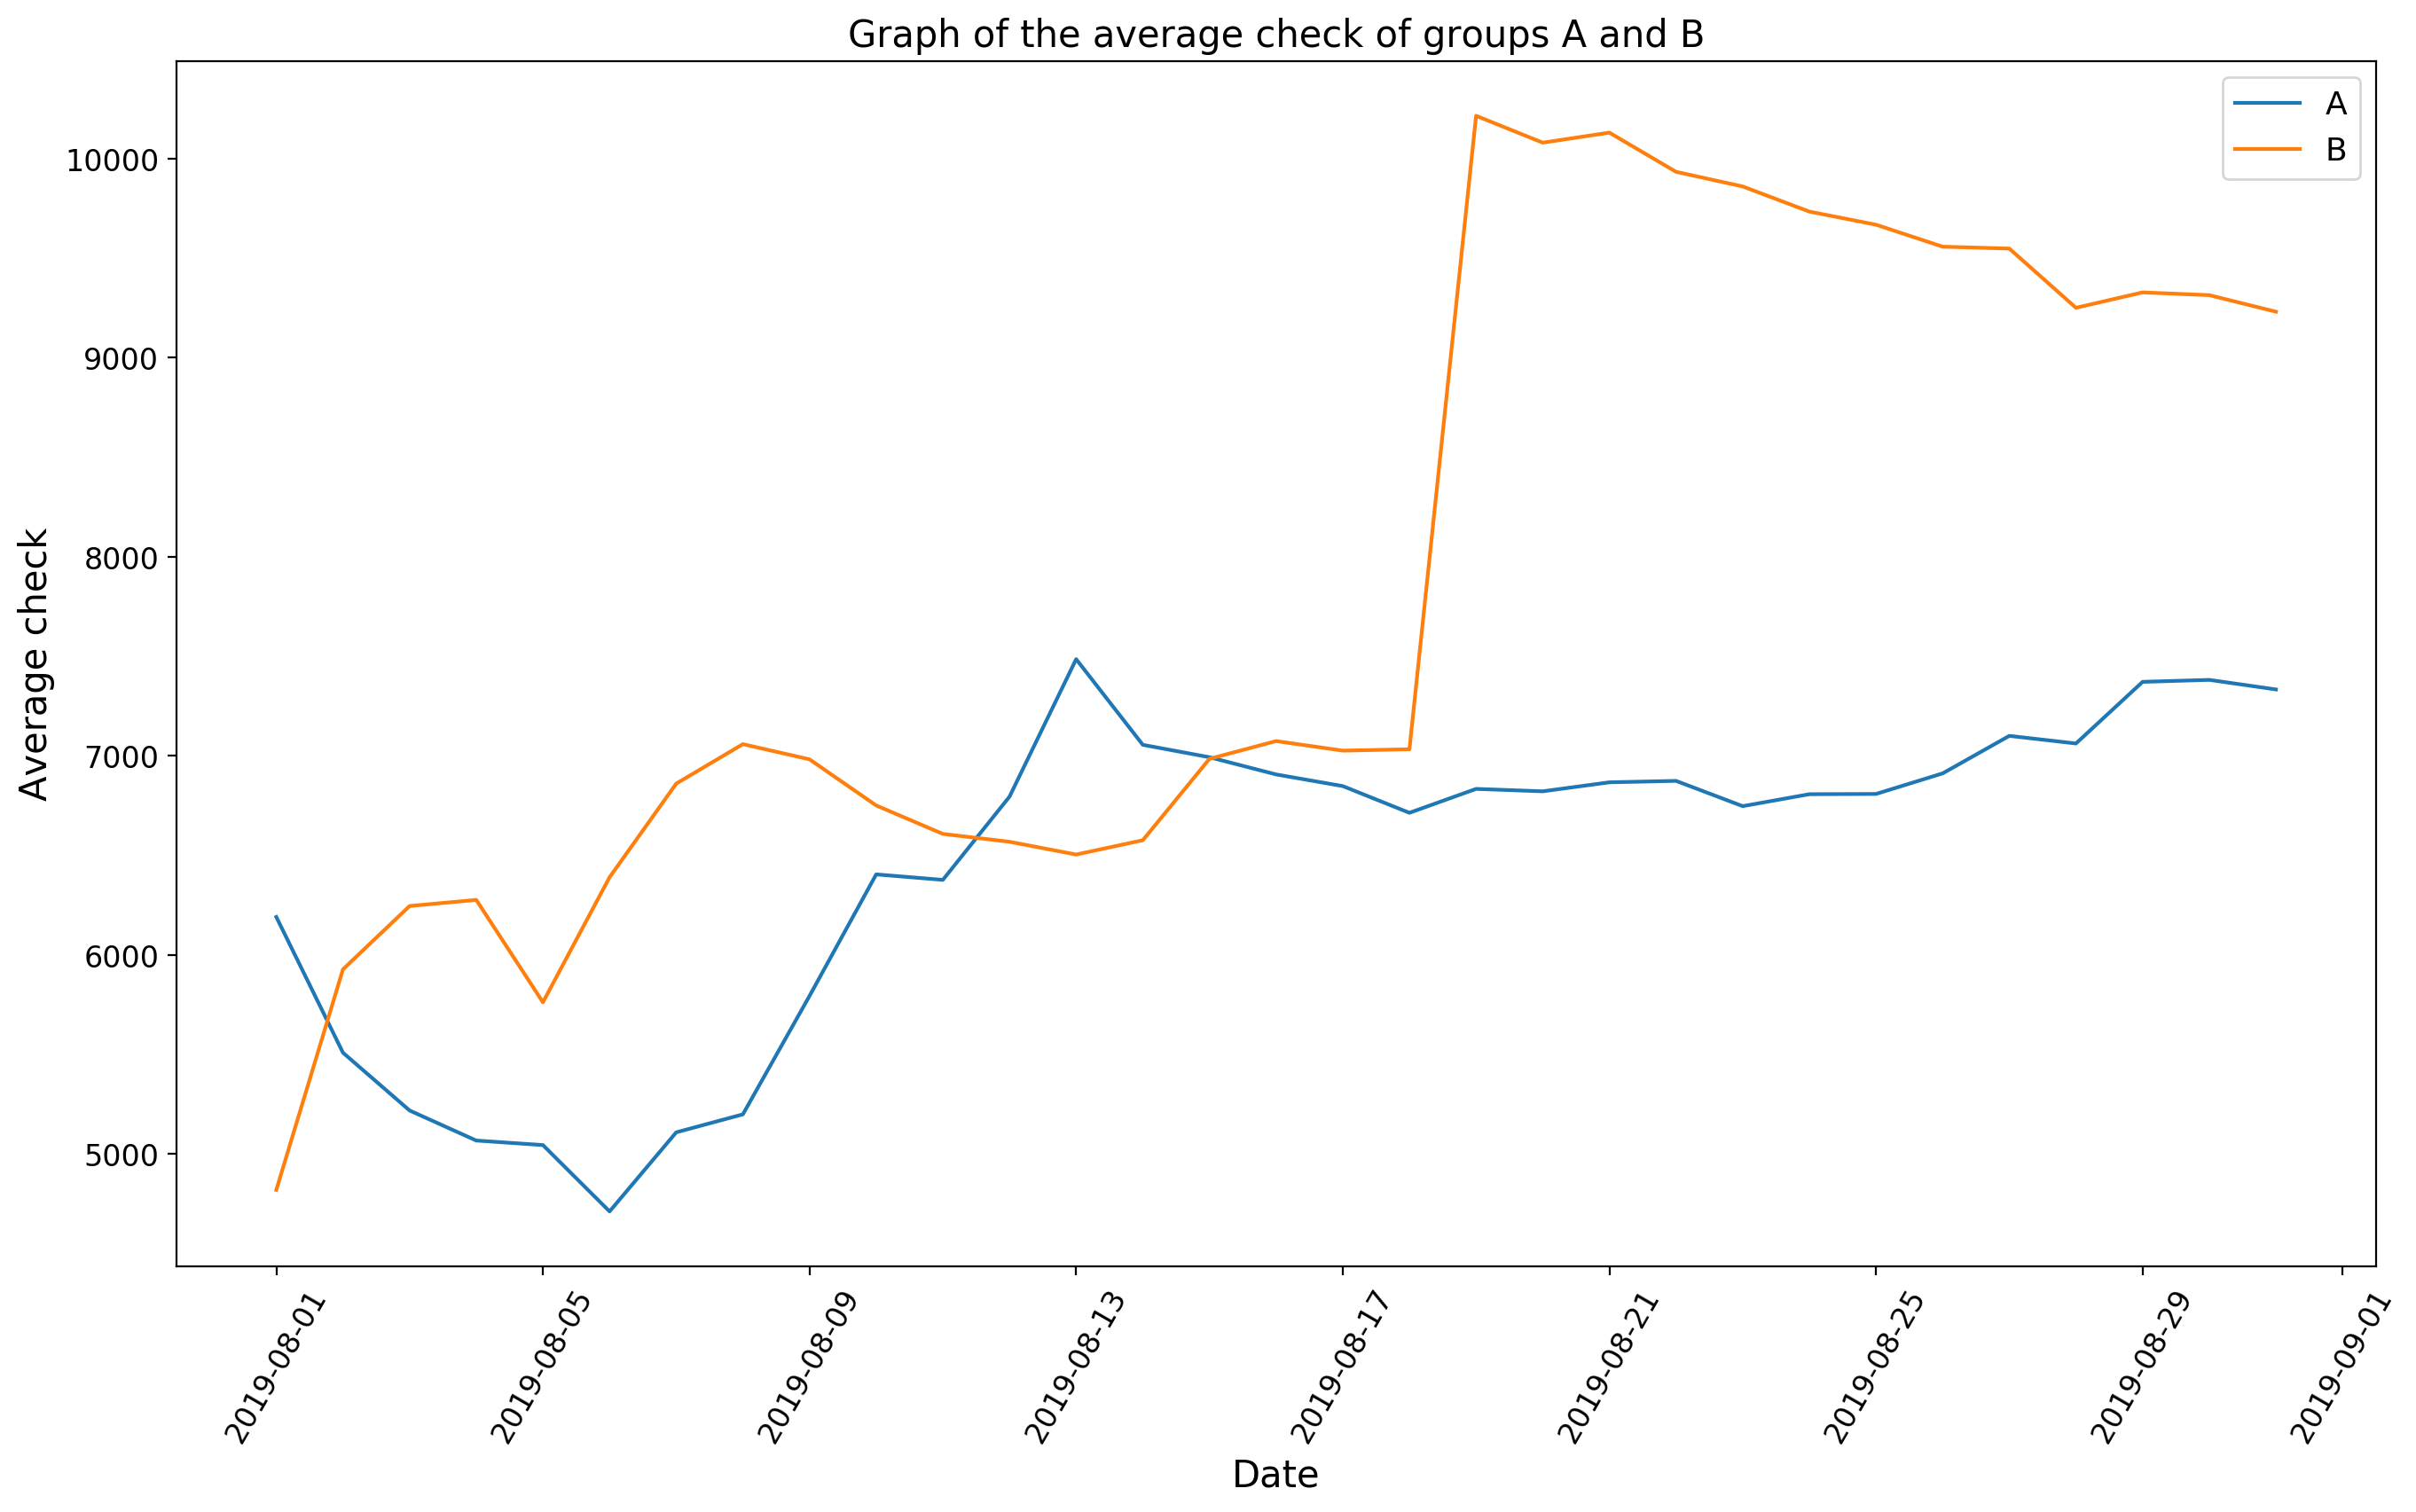

In [11]:
# строим график
group_chart('Date', 'Average check', a = cumulativeRevenueA, b = cumulativeRevenueB)

**Вывод**  

На графике наблюдаем схожий подскок среднего чека, как и на предыдущем графике, но в случае с группой А, средний чек к концу теста установился, то средний чек группы В падает.

## Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.

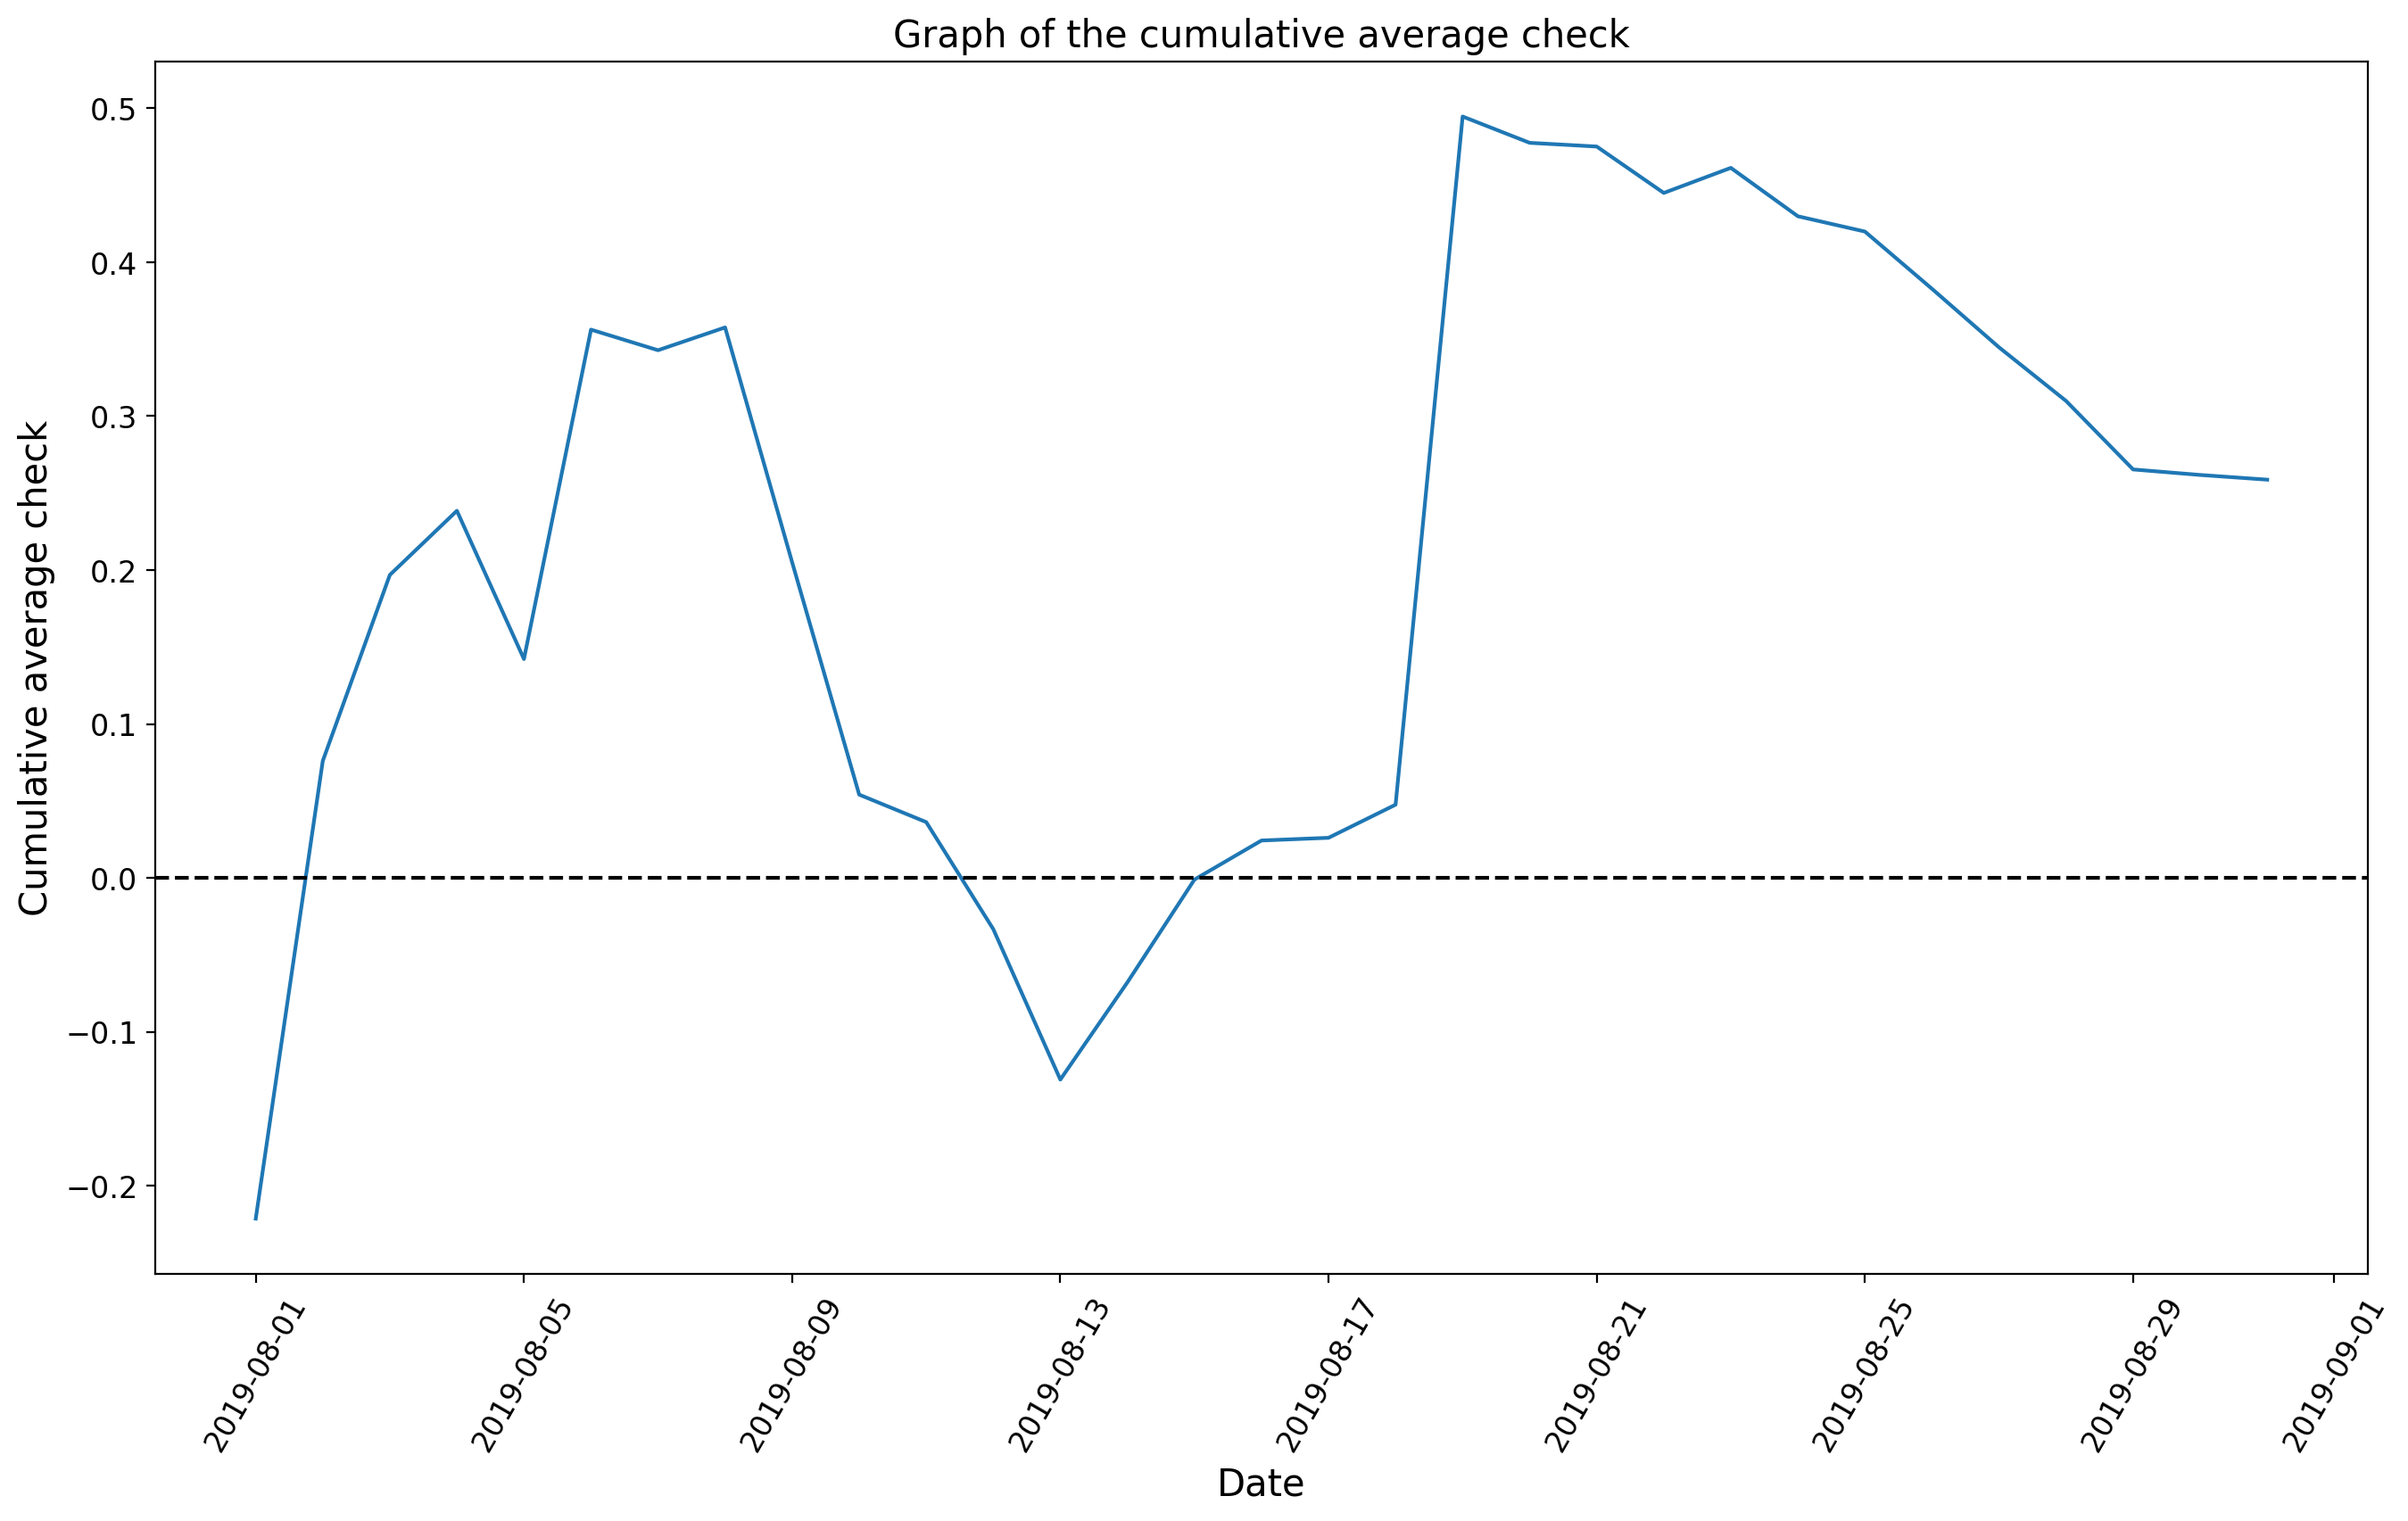

In [12]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date',
                                                   right_on='date', how='left', suffixes=['A', 'B'])

# строим график
group_chart('Date', 'Cumulative average check', m = mergedCumulativeRevenue)

**Вывод**  

В нескольких точках график резко «подскакивает». Скорей всего это крупные заказы и выбросы.

## Построить график кумулятивной конверсии по группам. Сделать выводы и предположения.

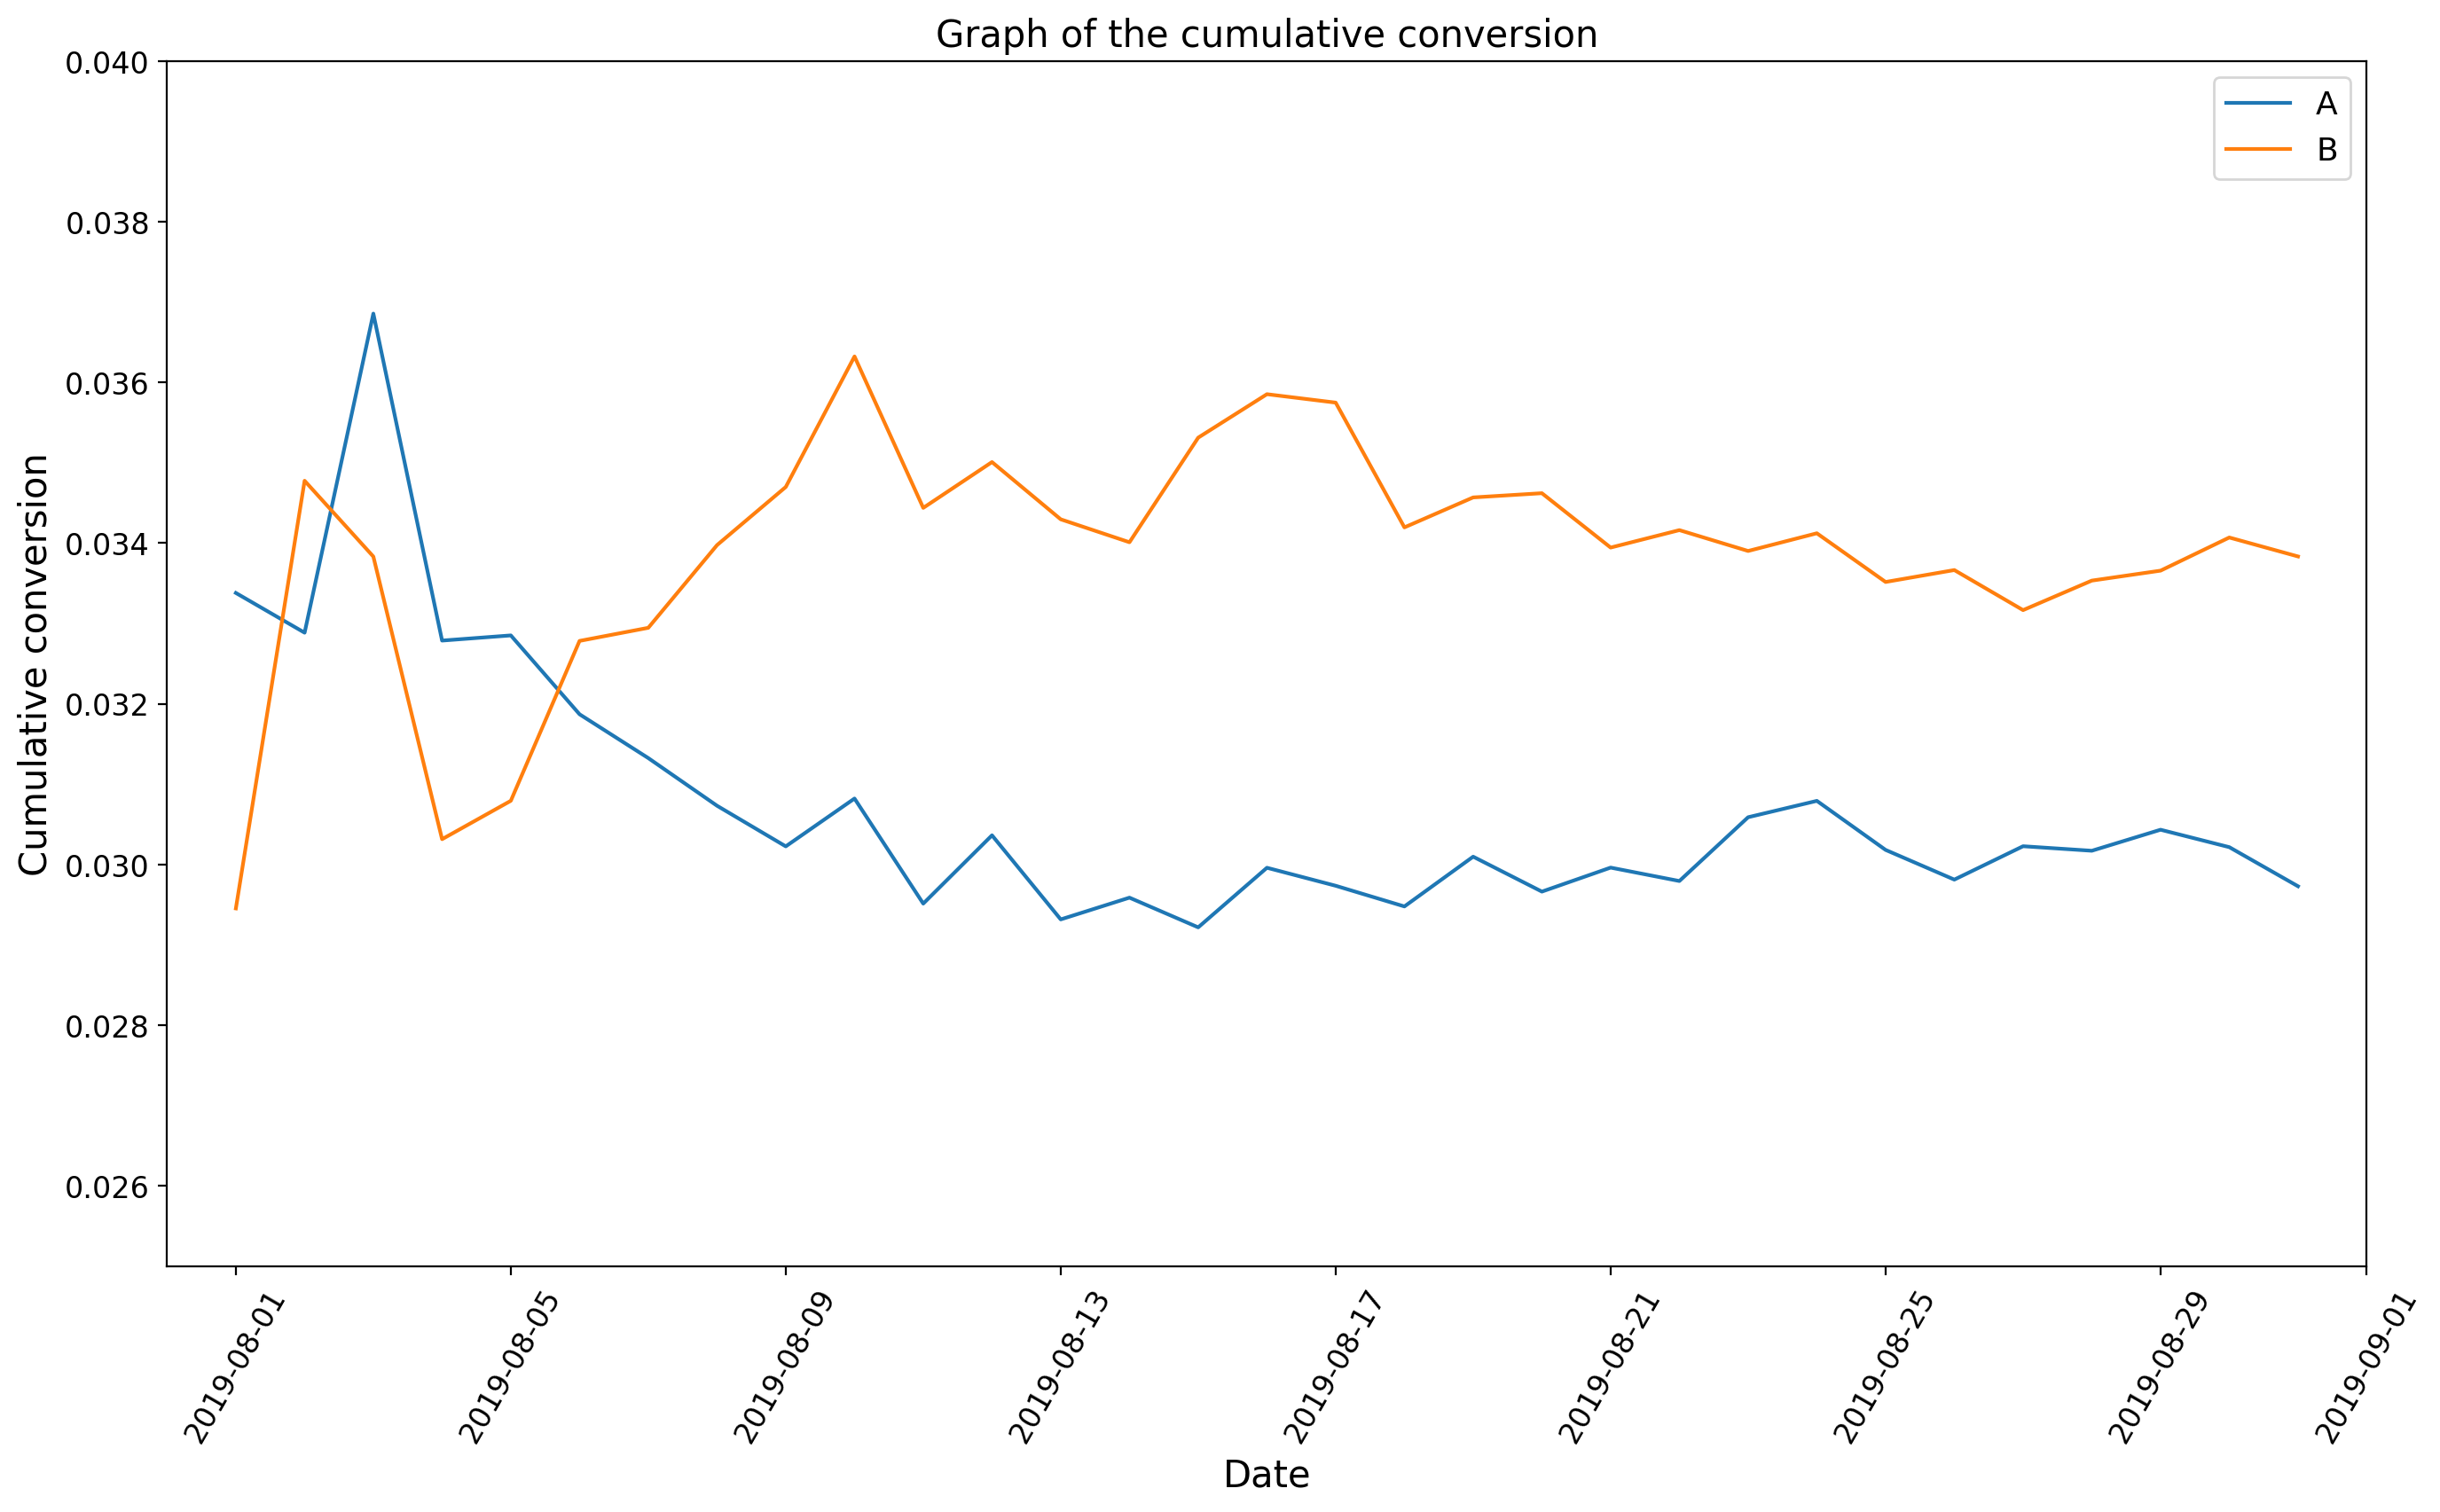

In [13]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим график
group_chart('Date', 'Cumulative conversion', a = cumulativeDataA, b = cumulativeDataB)

**Вывод**  

Конверсия группы В вырвалась вперёд и понемногу падает, конверсия группы А просела и колеблится примерно на одной отметке.

## Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения.

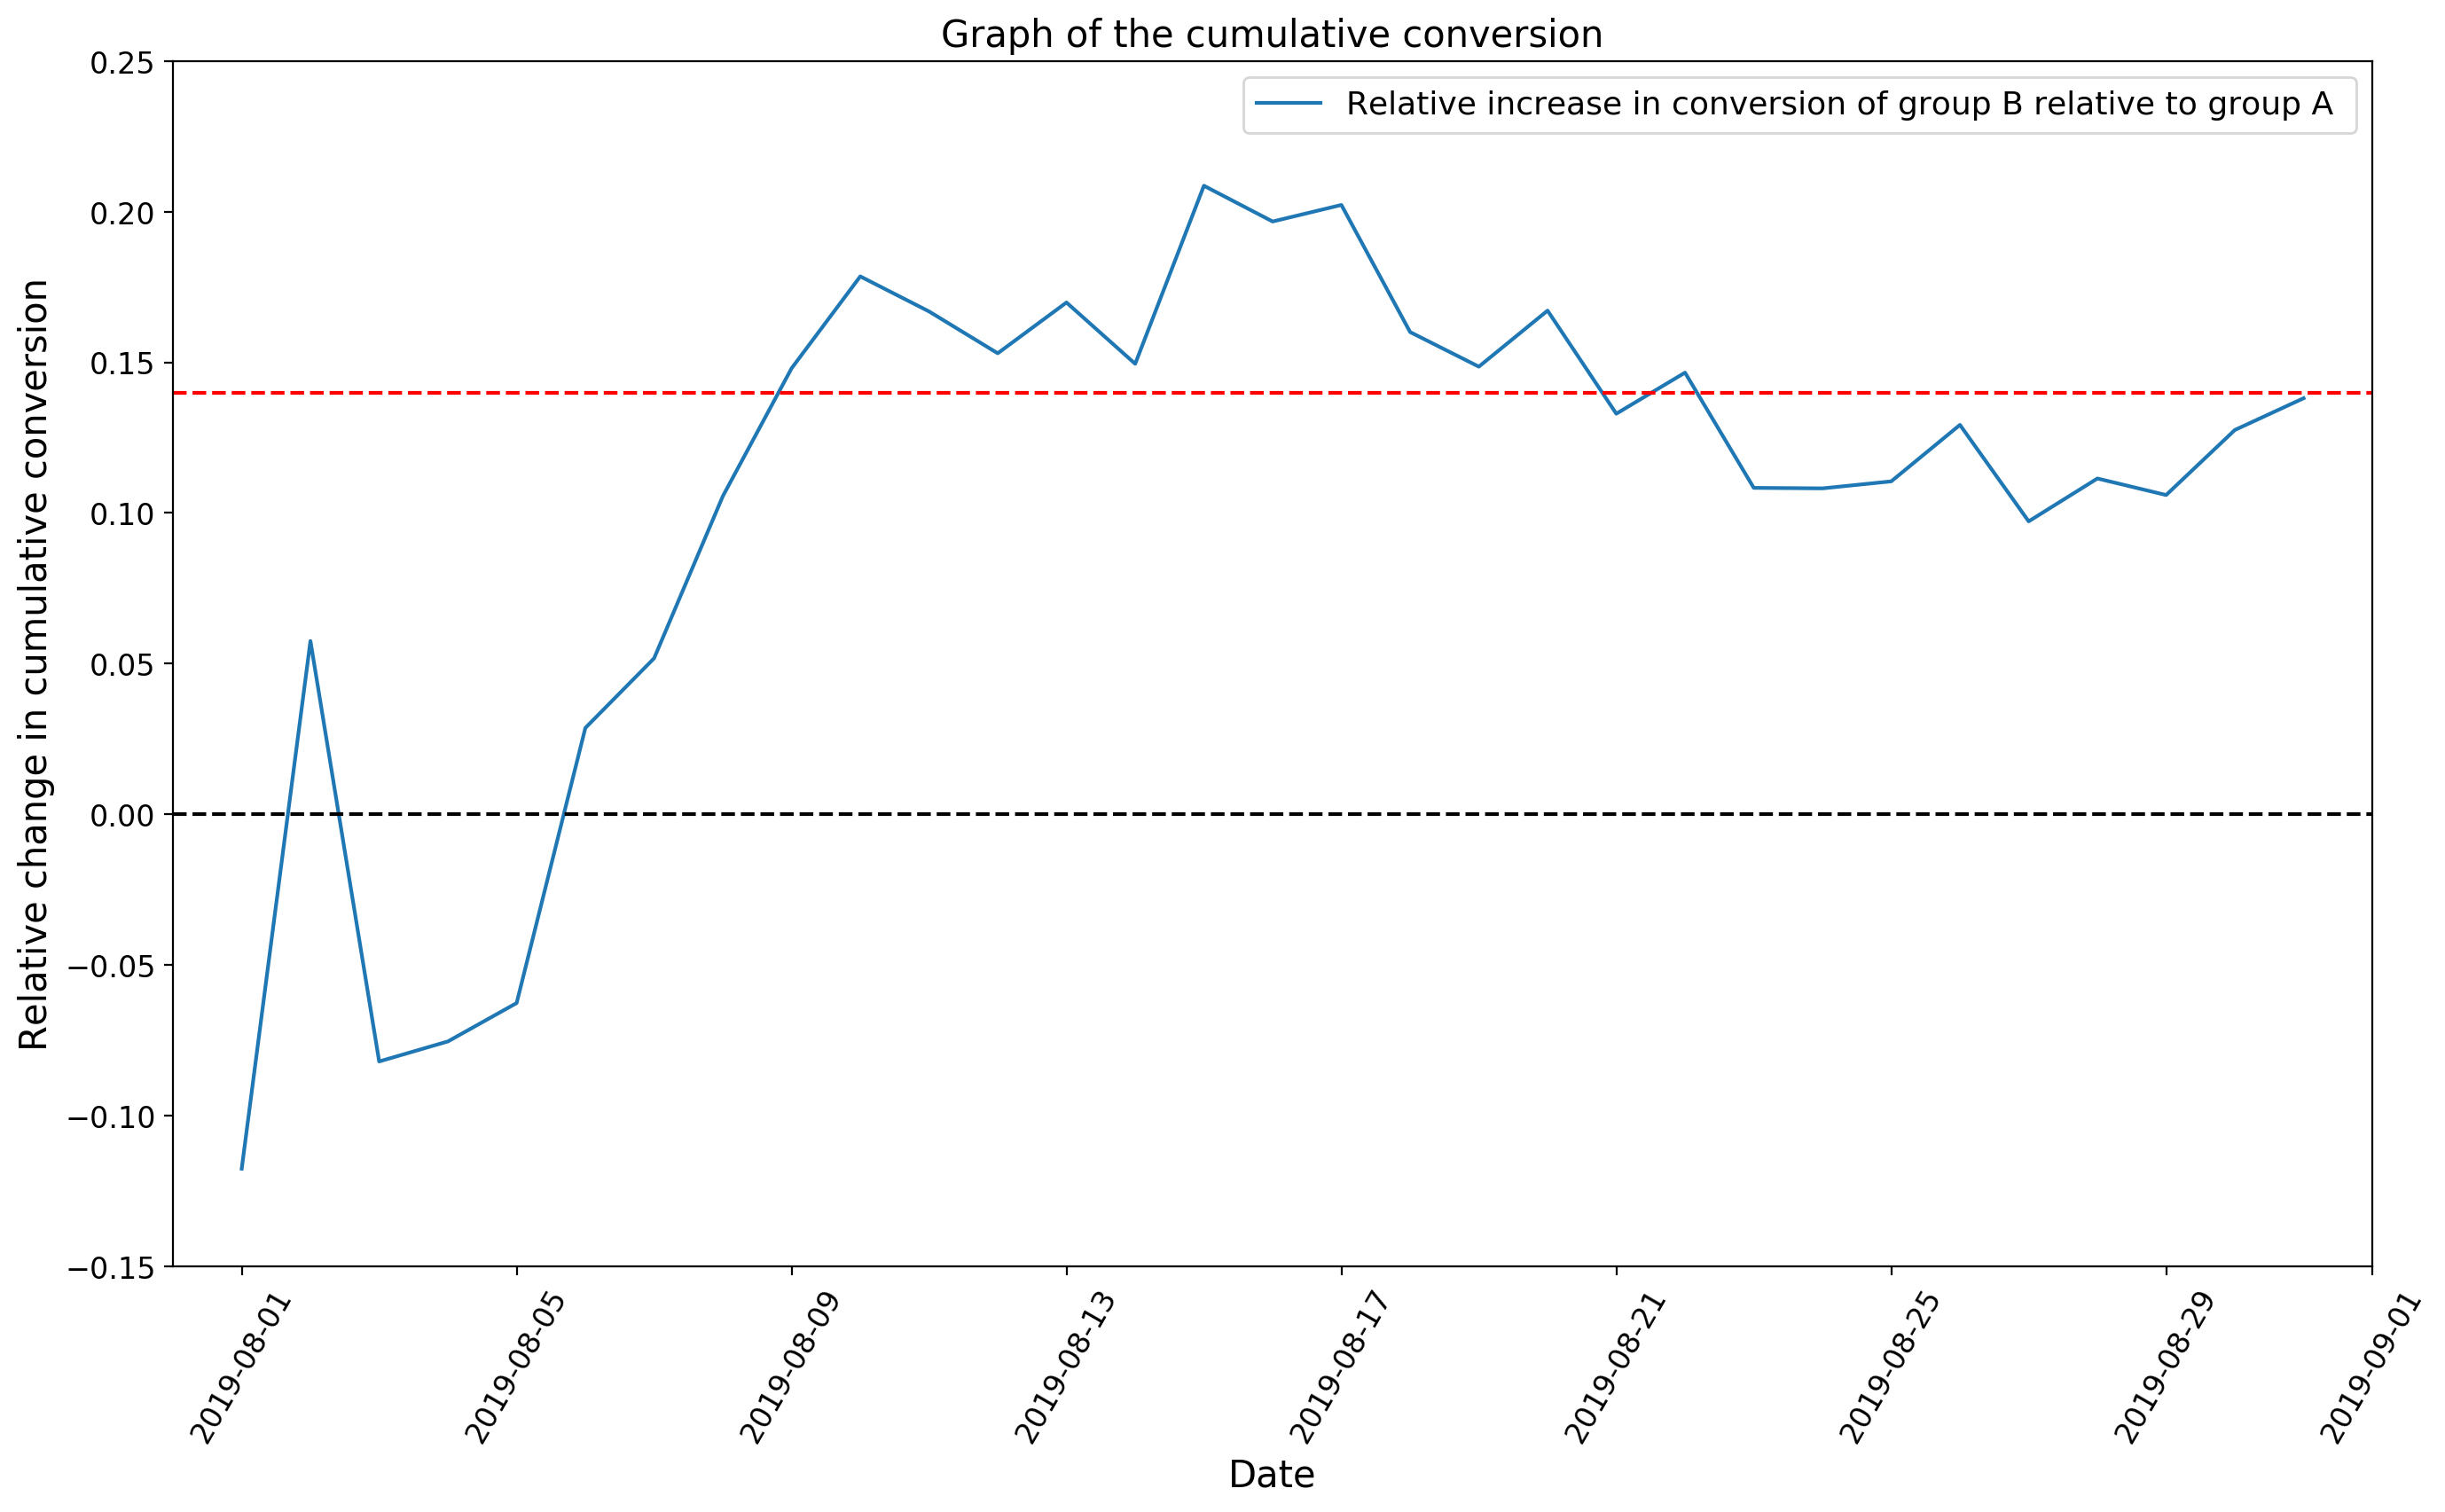

In [14]:
# собираем данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']],
                                                                           left_on='date',
                                                                           right_on='date',
                                                                           how='left',
                                                                           suffixes=['A', 'B'])

# строим график
group_chart('Date', 'Relative change in cumulative conversion', m = mergedCumulativeConversions)

**Вывод**  

В начале теста группа B резко выросла и в течении пары дней резко упала относительно группы A, затем начала уверено расти вперёд. Потом её конверсия начала постепенно падать, но под конец теста начала снова расти.

## Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.

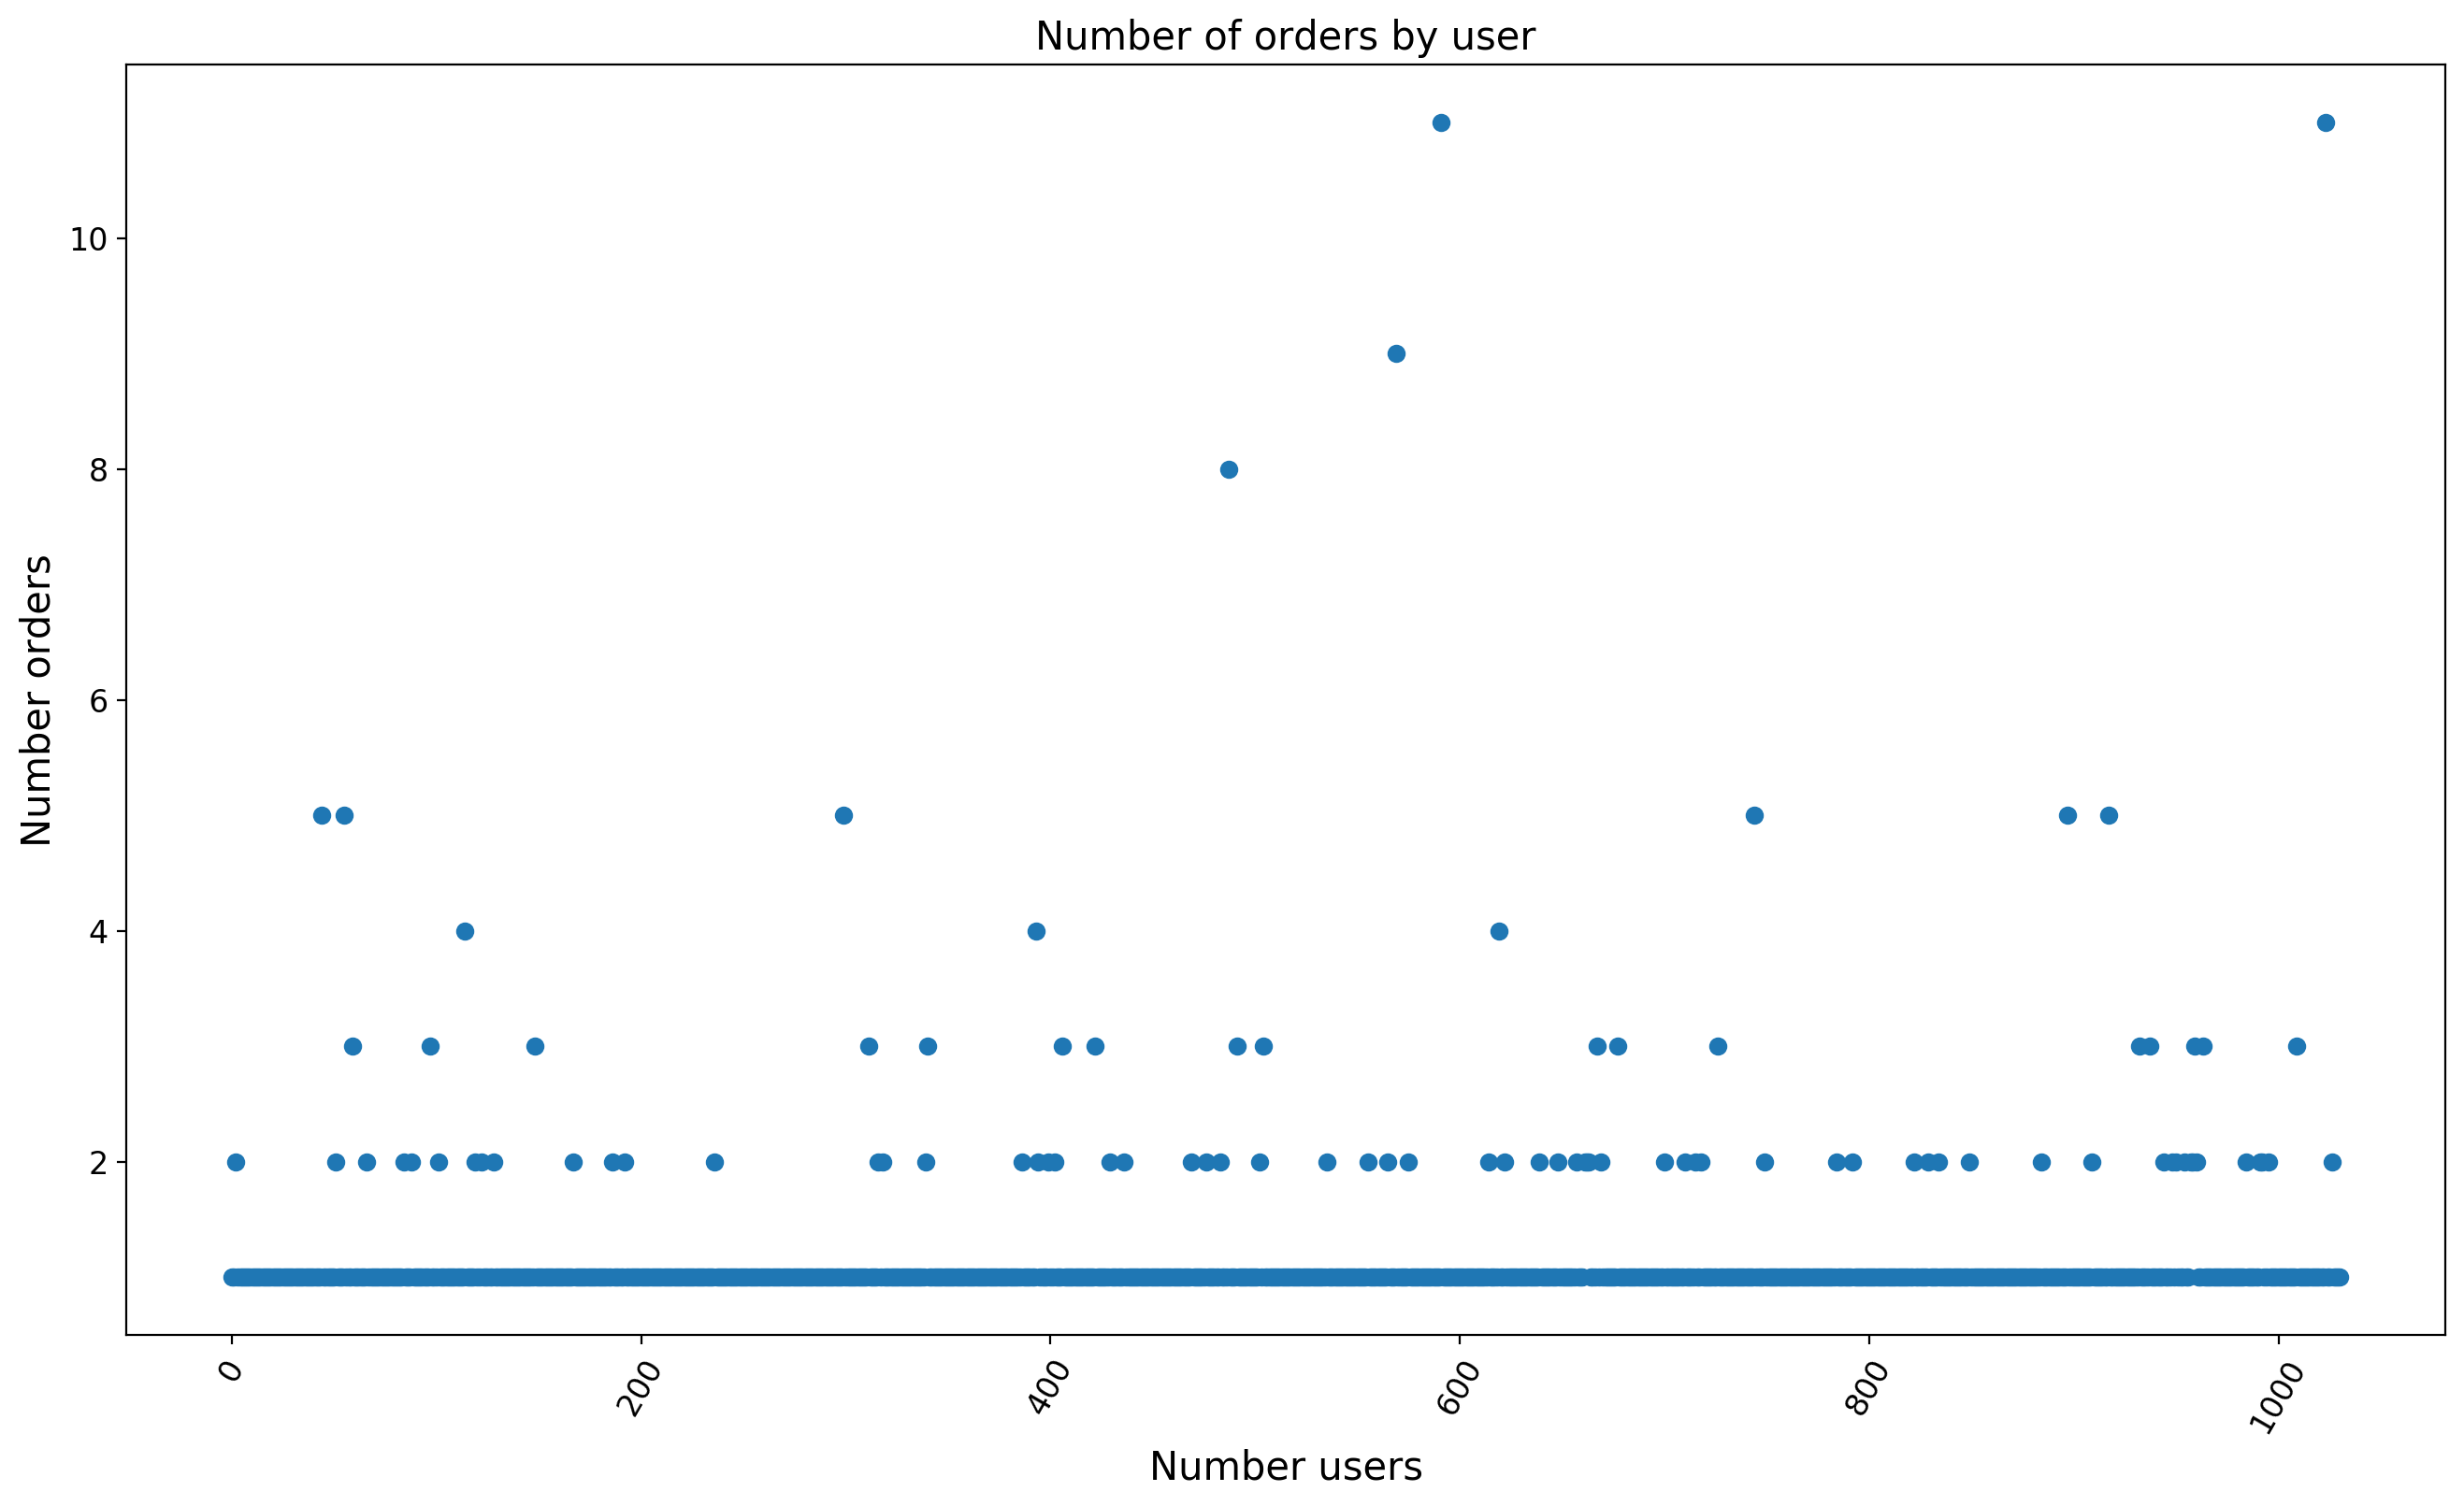

In [15]:
# считаем количество заказов для каждого пользователя
number_orders_by_user = orders.groupby('visitorid', as_index=False).agg({'transactionid':'nunique'})\
.rename(columns={'visitorid':'users', 'transactionid':'number_orders'})

# количество пользователей
x_values = pd.Series(range(0,len(number_orders_by_user['number_orders'])))

# строим график
group_chart('Number users', 'Number orders',
            u = x_values,
            o = number_orders_by_user['number_orders'],
            title = 'Number of orders by user',
            anchor = 'scatter')

**Вывод**  

Есть несколько пользователей, которые покупают чаще остальных. По графику можно выбрать границу аномального количества заказов равную 2.

## Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.

In [16]:
# рассчитаем и выведим перцентиль
print(np.percentile(number_orders_by_user['number_orders'], [95, 99]))

[2. 4.]


**Вывод**  

Не более 5% пользователей оформляли больше чем 2 заказа.  
Не более 1% пользователей оформляли больше чем 4 заказа.  
Примем 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеим аномальных пользователей по ней.

## Построить точечный график стоимостей заказов. Сделать выводы и предположения.

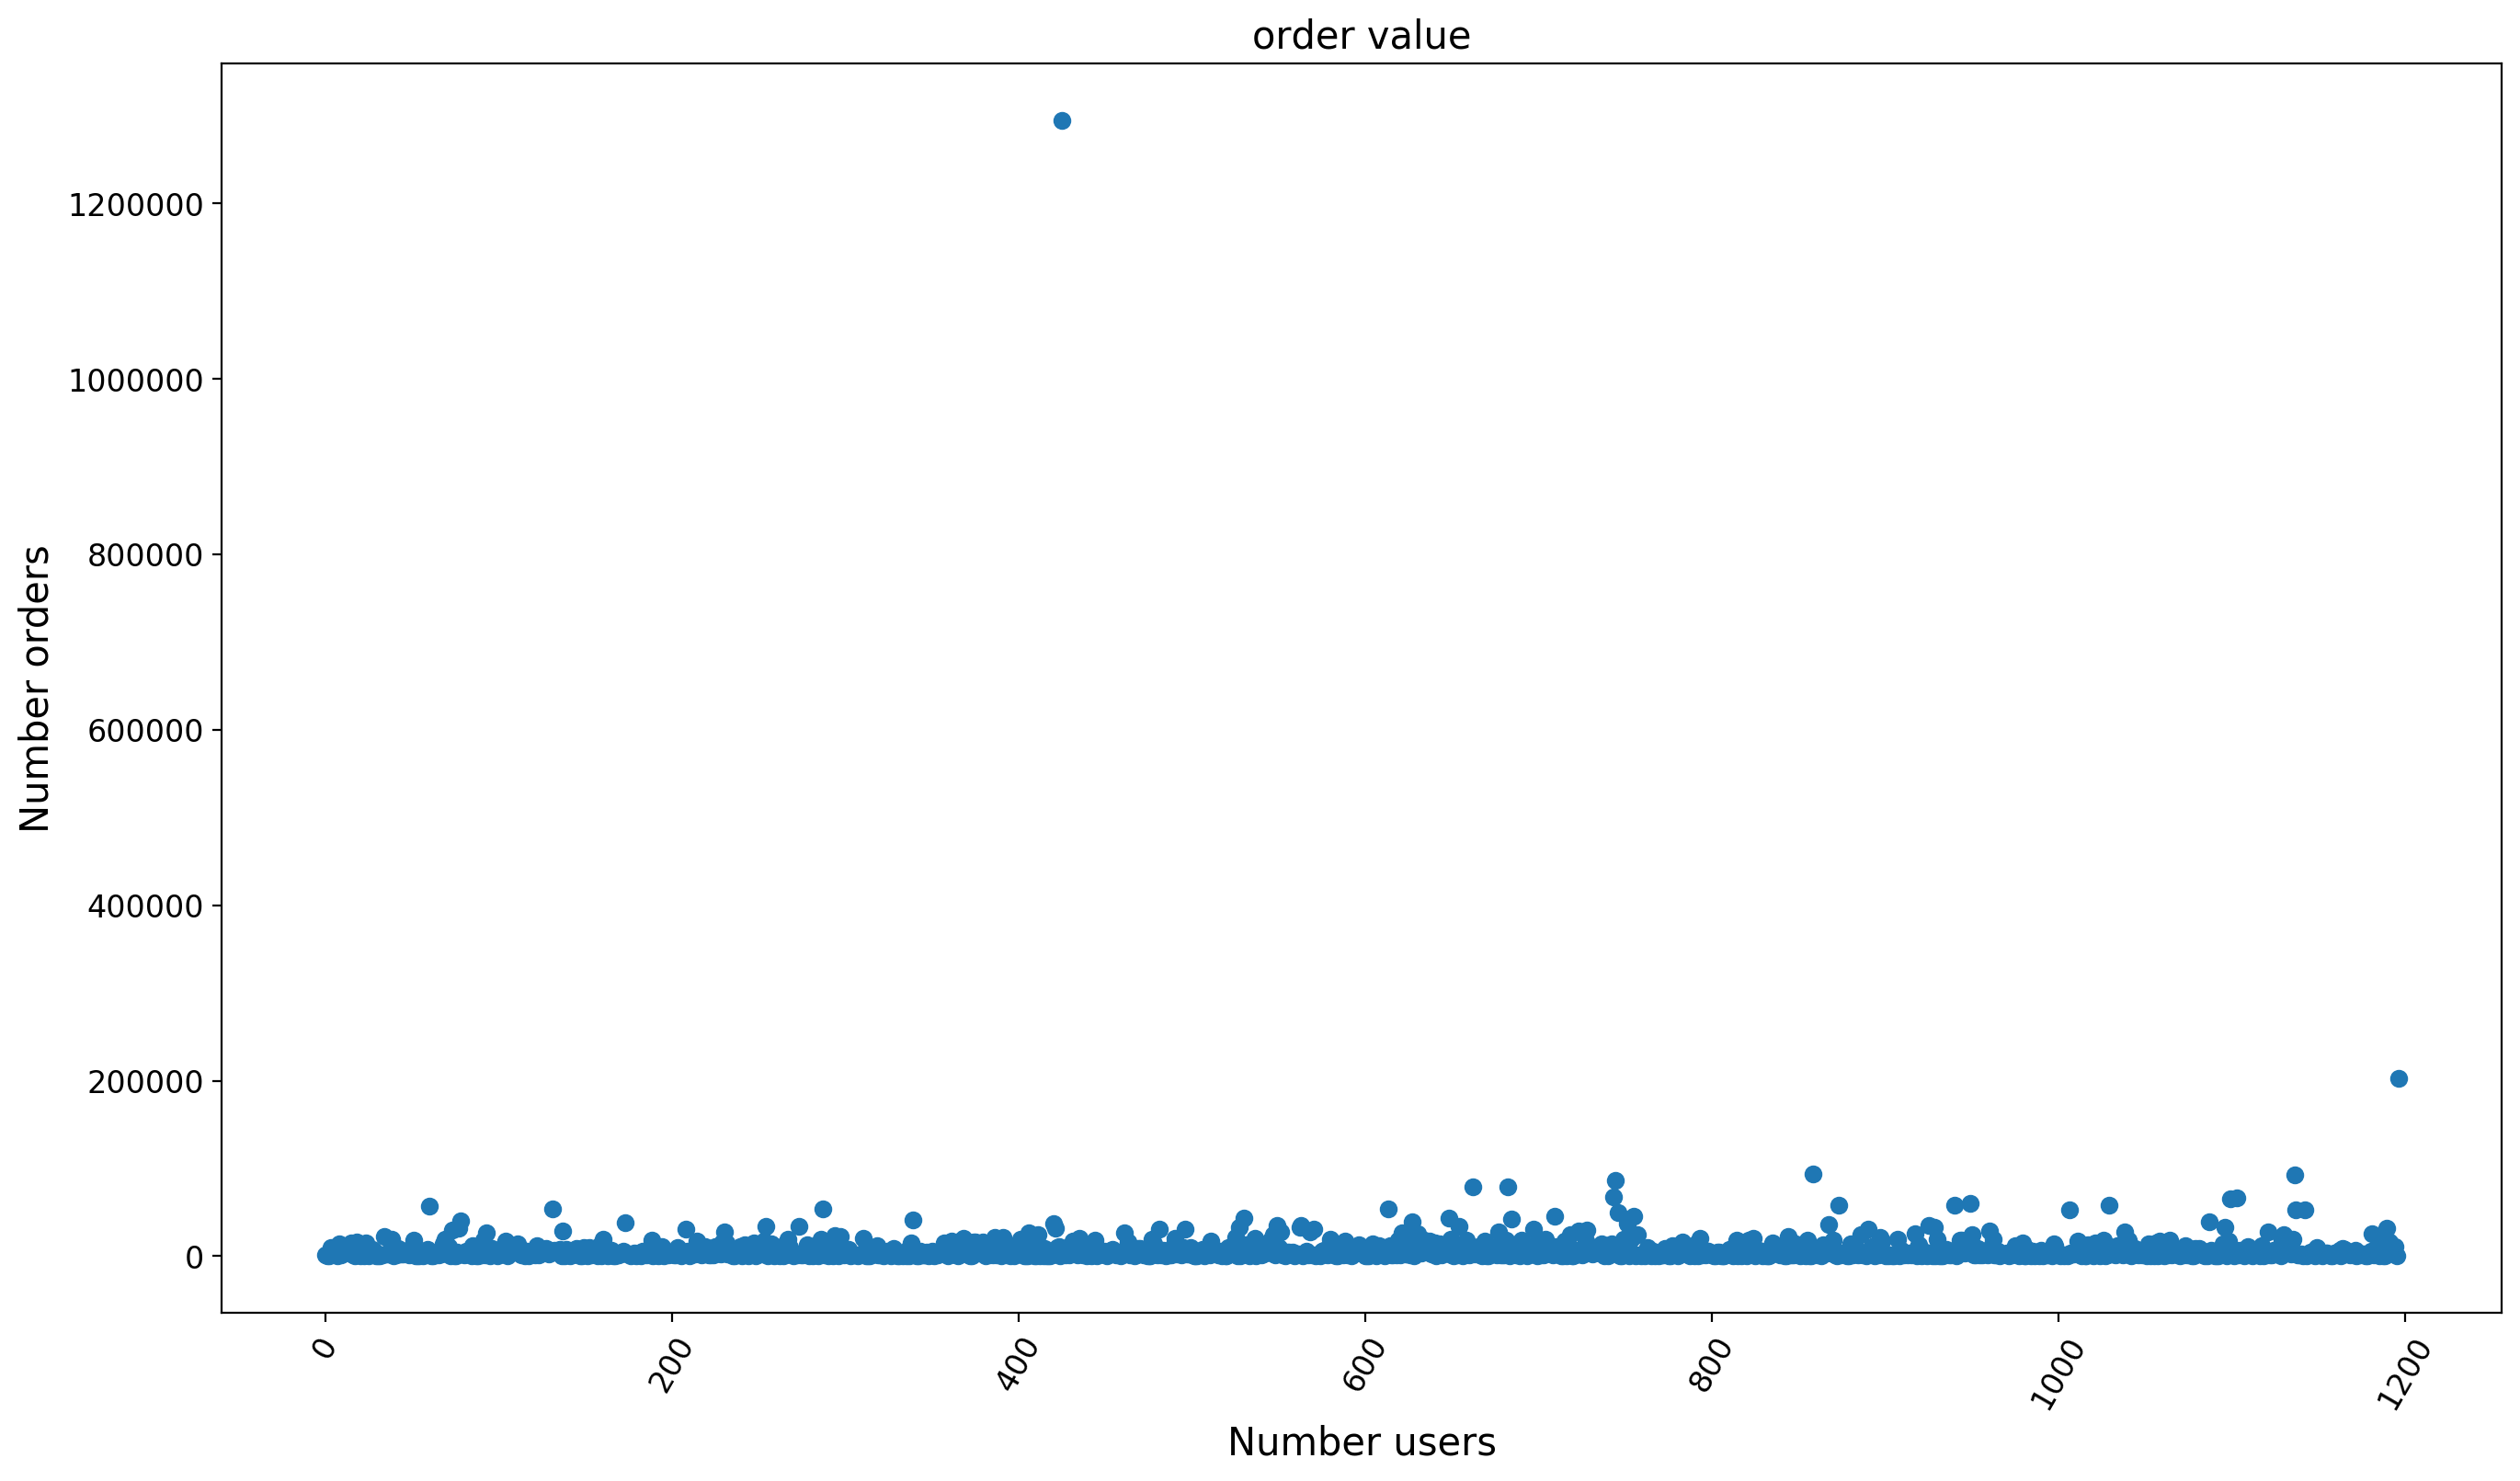

In [17]:
# количество покупок
x_values = pd.Series(range(0,len(orders['revenue'])))

# строим график
group_chart('Number users', 'Number orders', u = x_values, o = orders['revenue'], title = 'order value', anchor = 'scatter')

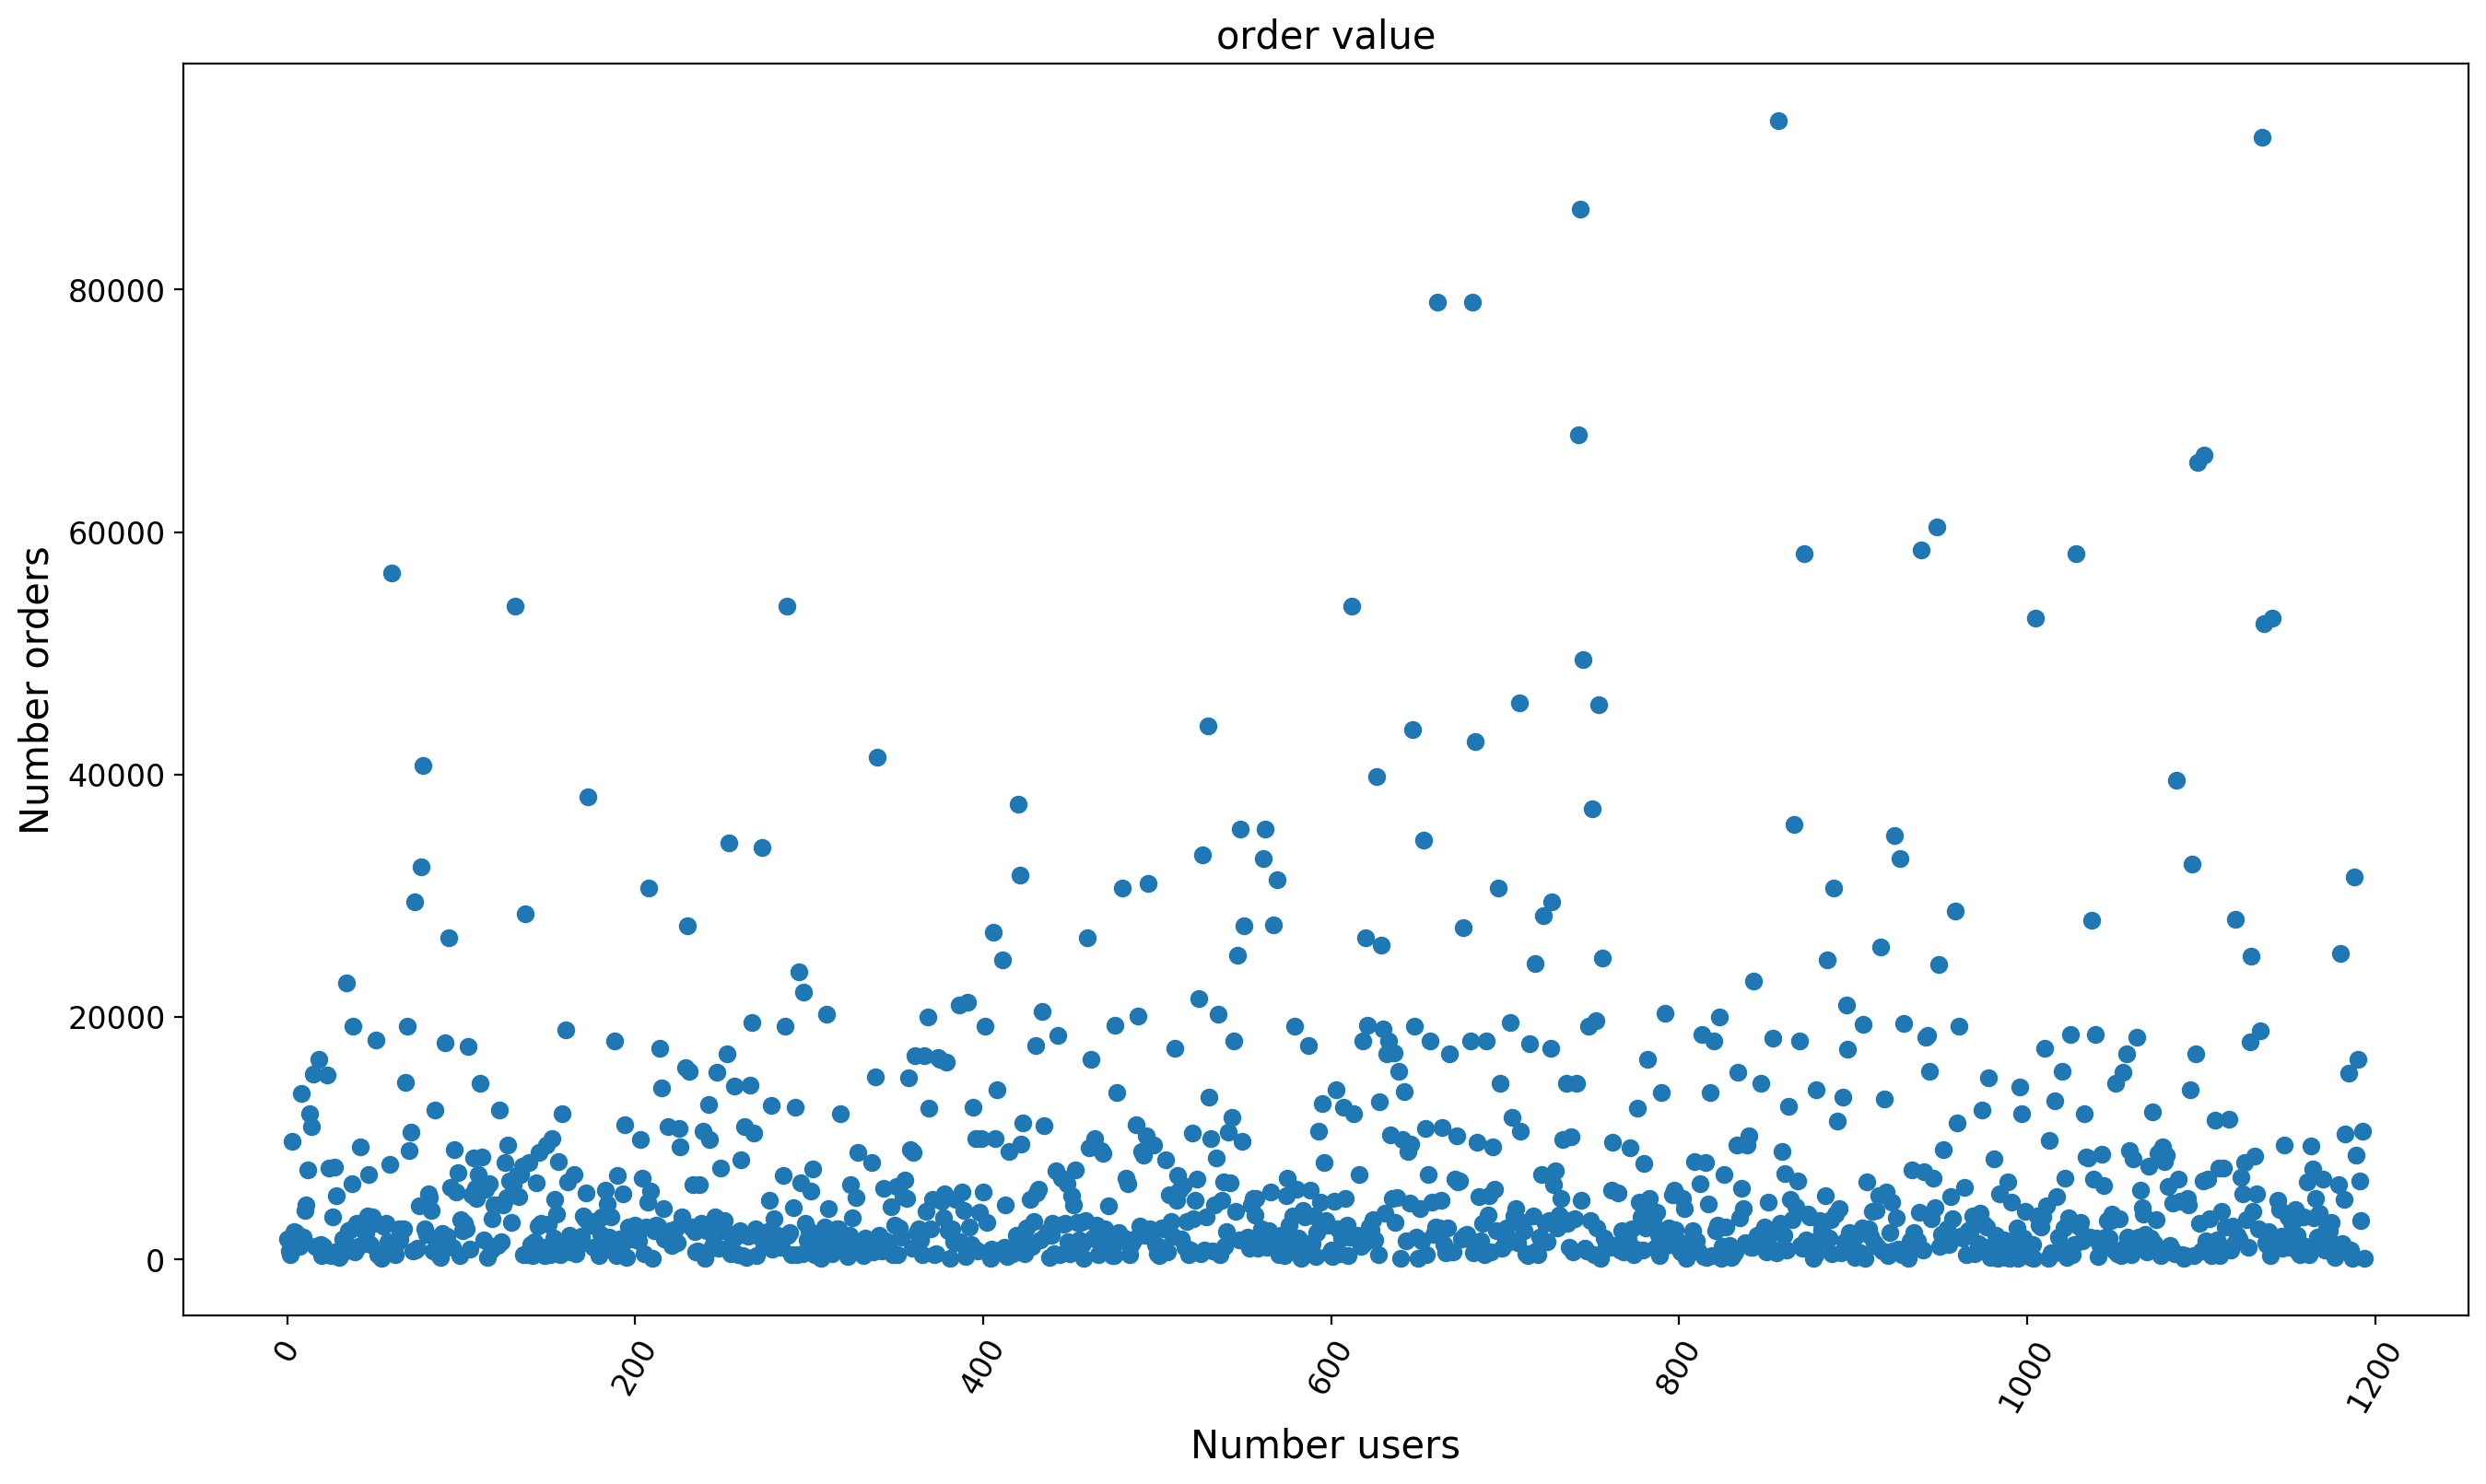

In [18]:
# убираем явные выбросы
orders_no_emissions  = orders[orders['revenue'] < 180000]

# количество покупок
x_values = pd.Series(range(0,len(orders_no_emissions['revenue'])))

# строим график
group_chart('Number users', 'Number orders', u = x_values, o = orders_no_emissions['revenue'],
            title = 'order value', anchor = 'scatter')

**Вывод**  

Есть 2 заказа выбивающихся из общей картины, один свыше 1.2 млн и один до 200000. Оба заказа влияют на результат теста. На втором графике видно еще несколько заказов, которые подходят под определение 'выбросы'. По графику можно выбрать границу аномальных заказов свыше 30000 рублей.

## Построить 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.

In [19]:
# рассчитаем и выведим перцентиль
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


**Вывод**  

Не более 5% пользователей оформляли больше чем 28000.  
Не более 1% пользователей оформляли больше чем 58000.  
Примем 28000 за нижнюю границу и отсеим аномальныt покупки по ней.

## Построить статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.

In [20]:
# подготовка данных
# получаем данные о посетителях по дням. Группа А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# получаем агрегированные кумулятивные по дням данные о посетителях. Группа А
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# получаем данные о посетителях по дням. Группа В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# получаем агрегированные кумулятивные по дням данные о посетителях. Группа В
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# получаем данные о заказах по дням. Группа А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitorid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# получаем агрегированные кумулятивные по дням данные о заказах. Группа А
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# получаем данные о заказах по дням. Группа В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'visitorid', 'transactionid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitorid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# получаем агрегированные кумулятивные по дням данные о заказах. Группа В
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# объединяем кумулятивные данные в одной таблице
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

<div class="alert alert-danger">

**Комментарий ревьюера**
    
Важно **сформулировать нулевую и альтернативную гипотезы** перед проведением стат тестов. Это позволяет сделать анализ полным: от гипотезы к выводам. Также в рамках обучения мне важно увидеть, что у тебя с этим нет проблем.
    
Это можно сделать **для каждой проверки или сразу для всех в общей формулировке**.
</div>

<div class="alert alert-info">

**Комментарий студента**
    
Ниже добавил комментарий с нулевой и альтернативной гепотезами.
    
</div>

<div class="alert alert-success">

**Комментарий ревьюера v2**
    
Гипотезы сформулированы верно. Отлично!
</div>

In [21]:
# Cчитаем статистическую значимость различия в конверсии между группами

# Для пользователей группы А, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

# Для пользователей группы В, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

# В переменной sampleA, пользователям из группы А будет соответствовать количество заказов. "Сырые" данные
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# В переменной sampleB, пользователям из группы В будет соответствовать количество заказов. "Сырые" данные
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# проверяем гипотезу
def hypothesis_testing(a, b):
    alpha = .05
    p_value = stats.mannwhitneyu(a, b, alternative='two-sided')[1]
    relative_gain_loss = b.mean() / a.mean() - 1
    
    print('\033[1m' + 'Вывод:' + '\033[0m')
    print("p_value: {0:.3f}".format(p_value))
    
    if p_value < alpha:
        print('Отвергаем нулевую гепотезу')
    else:
        print('Не отвергаем нулевую гепотезу')
    
    if relative_gain_loss > 0:
        print("Относительный выйгрыш группы B равен {0:.1%}".format(relative_gain_loss))
    else:
        print("Относительный проигрыш группы B равен {0:.1%}".format(relative_gain_loss))


# сформулируем нулевую и альтернативную гипотезы
# H0: Нет статистически значимых различия в конверсии и среднем чеке между группами по «сырым» данным
# H1: есть статистически значимые различия в конверсии и среднем чеке между группами по «сырым» данным
hypothesis_testing(sampleA, sampleB)

Вывод:
p_value: 0.017
Отвергаем нулевую гепотезу
Относительный выйгрыш группы B равен 13.8%


## Построить статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.

In [22]:
hypothesis_testing(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

Вывод:
p_value: 0.729
Не отвергаем нулевую гепотезу
Относительный выйгрыш группы B равен 25.9%


## Построить статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.

In [23]:
orders

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [24]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('\nВсего {} аномальных пользователей.'.format(abnormalUsers.shape[0]) )

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64

Всего 74 аномальных пользователей.


In [25]:
# В переменной sampleAFiltered, пользователям из группы А будет соответствовать количество заказов. "Очищеные" данные
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# В переменной sampleBFiltered, пользователям из группы В будет соответствовать количество заказов. "Очищеные" данные
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [26]:
# сформулируем нулевую и альтернативную гипотезы
# H0: Нет статистически значимых различия в конверсии и среднем чеке между группами по «очищеным» данным
# H1: есть статистически значимые различия в конверсии и среднем чеке между группами по «очищеным» данным
hypothesis_testing(sampleAFiltered, sampleBFiltered)

Вывод:
p_value: 0.013
Отвергаем нулевую гепотезу
Относительный выйгрыш группы B равен 17.3%


## Построить статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.

In [27]:
hypothesis_testing(orders[np.logical_and(orders['group'] == 'A',
                                         np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
                  orders[np.logical_and(orders['group'] == 'B',
                                        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue']
                  )

Вывод:
p_value: 0.738
Не отвергаем нулевую гепотезу
Относительный проигрыш группы B равен -2.0%


## Принять решение по результатам теста и объяснить его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

**Фаткы:**  

    1. Есть статистически значимое различие по конверсии между группами по «сырым» и по данным после фильтрации аномалий
    2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий
    3. График различия конверсии между группами сообщает, что результаты группы B лучше группы A.

**Вывод**  

    1. Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Фисируем победу группы В (вариант №1).